In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
import seaborn as sns
import matplotlib.pyplot as plt

### Initial exploration

In [2]:
aqi = pd.read_csv('./data/daily_aqi_by_county_2015.csv', parse_dates = ['Date'])

In [3]:
aqi['month'] = aqi['Date'].dt.month
aqi['year'] = aqi['Date'].dt.year

In [4]:
state_county = aqi[['State Name','county Name']].groupby('State Name')[['county Name']].nunique().reset_index().sort_values('State Name')
state_county['num_of_county'] = np.array([67,19,15,75,58,64,8,9999,3,1,67,159,5,44,102,92,99,105,120,64,14,24,14,83,
                                         87,82,114,56,93,16,10,21,33,62,100,53,88,77,36,67,78,5,46,66,95,254,29,
                                         14,3,133,39,55,72,23])
state_county

,State Name,county Name,num_of_county
0,Alabama,18,67
1,Alaska,8,19
2,Arizona,13,15
3,Arkansas,11,75
4,California,54,58
5,Colorado,31,64
6,Connecticut,8,8
7,Country Of Mexico,1,9999
8,Delaware,3,3
9,District Of Columbia,1,1


Many states in the data set don't include all county data. Potentially it means we will need to interpolate the data to cover a wider zipcode range.

In [5]:
aqi.groupby('State Name')[['AQI']].mean().reset_index().sort_values(by='AQI',ascending=False).head(10)

,State Name,AQI
7,Country Of Mexico,80.875000
4,California,55.914555
12,Hawaii,55.019218
9,District Of Columbia,49.764384
2,Arizona,47.591863
8,Delaware,46.366210
46,Utah,45.806485
6,Connecticut,45.511610
21,Maryland,45.373291
39,Pennsylvania,45.223348


In [6]:
aqi['Defining Parameter'].value_counts()

Ozone    177181
PM2.5    120820
PM10      13490
SO2       12780
NO2        5861
CO          490
Name: Defining Parameter, dtype: int64

__There are 5 different type of AQI, namely 'CO', 'SO2' 'NO2', 'Ozone', 'PM10', and 'PM2.5'.__

- NO2: Nitrogen oxide is mainly an unwanted by-product of fuel combustion at high temperatures. Cars and power plants are the main sources of nitrogen oxide.
- Ozone: Major sources of ozone are the chemical processes caused by industry and traffic as well as electrical current of television sets, computers, photocopiers, and electric motors (using brushes).
- SO2: SO2 mainly comes from burning coal and heavy fuel oil. Major sources are firing systems in energy business, in industry, and small-scale heating systems that use poor quality sulfurous oil or coal.
- CO: Carbon monoxide is mainly a product of incomplete combustion of fuel and propellants. Major sources are traffic, industry and smoking indoors.
- PM10 & PM2.5: Particulate matter comes from diesel exhaust particles, tire wear, brake dust, and swirling road dust generated by vehicle traffic.



__All indices are the lower the better. And we can see some types of data is missing for certain areas or time period.__

To facilitate the data analysis and deal with the missingness, we will combine all the chemical pollution to 'compound' and PMs to 'PMs'.

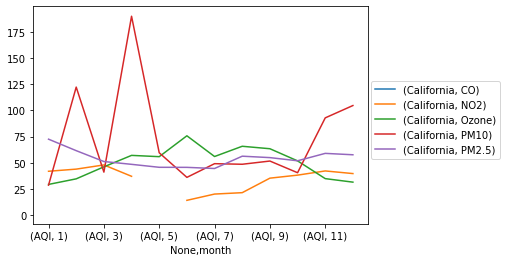

In [7]:
aqi[aqi['State Name'].isin(['California'])]\
 .groupby(['month','State Name','Defining Parameter'])[['AQI']].mean().unstack('month').T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

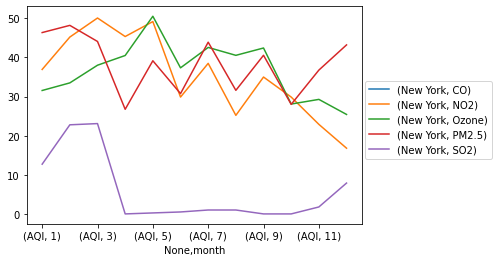

In [8]:
aqi[aqi['State Name'].isin(['New York'])]\
 .groupby(['month','State Name','Defining Parameter'])[['AQI']].mean().unstack('month').T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

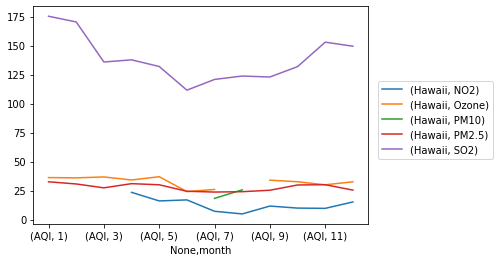

In [9]:
aqi[aqi['State Name'].isin(['Hawaii'])]\
 .groupby(['month','State Name','Defining Parameter'])[['AQI']].mean().unstack('month').T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

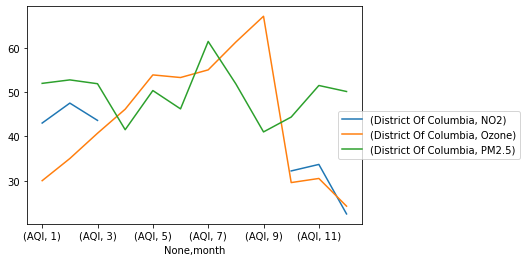

In [10]:
aqi[aqi['State Name'].isin(['District Of Columbia'])]\
 .groupby(['month','State Name','Defining Parameter'])[['AQI']].mean().unstack('month').T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

### Full data process for 2015-2018

In [11]:
file_list = ['./data/daily_aqi_by_county_'+str(i)+'.csv' for i in range(2015,2019)]

In [12]:
aqi_data = {}
for i in range(4):
    aqi_data[2015+i] = pd.read_csv(file_list[i],parse_dates = ['Date'])

In [13]:
for i in range(4):
    print(aqi_data[2015+i].shape)

(330622, 10)
(330420, 10)
(341026, 10)
(343408, 10)


In [43]:
def aqi_data_clean(df):
    
    '''
    This function cleans AQI daily by county dataframe.
    
    Arguments
    
    df : (Pandas dataframe) dataframe of interest
    
    Returns
    
    df1 : (Pandas dataframe) dataframe with modified column names, year and month column.
    
    '''
    
    #cleaning column names
    #adding month year column
    df1 = df.copy()
    df1.columns = df1.columns.str.lower().str.replace(' ','_')
    
    df1['month'] = df1['date'].dt.month
    df1['year'] = df1['date'].dt.year
    
    #checking missingness
    print(df1.isnull().sum()/df1.shape[0])
    print('\n')
    
    return df1

In [44]:
def california_prep(df, combine=True):
    
    '''
    This function filter the record of California only from cleaned AQI daily by county dataframe.
    
    Arguments
    
    df : (Pandas dataframe) dataframe of interest
    combine: (Boolean value) if True, the subcategories of air pollution sources will be combined, 
             the original columns will be dropped.
    
    Returns
    
    ca : (Pandas dataframe) dataframe of records from California and with modified column & missing
          data filled.
    
    '''
    
    ##extract California data
    ca = df[df['state_name']=='California'].groupby(['month','county_name','defining_parameter'])['aqi']\
                .mean().unstack('defining_parameter').reset_index()
    print(ca.shape)
    print('\n')
    
    #check missingness before fill 'na's
    print(ca.isnull().sum()/ca.shape[0])
    print('\n')
    
    #fill missing data with state/yearly average
    ca.fillna(ca.mean(),inplace=True)
    
    if combine:
        ca['compound'] = ca['NO2'] + ca['Ozone']
        ca['PMs'] = ca['PM2.5'] + ca['PM10']
        ca = ca[['month','county_name','compound','PMs']]
    
    return ca

In [20]:
aqi_clean_data = {}
for i in range(4):
    df = aqi_data_clean(aqi_data[2015+i])
    ca = california_prep(df)
    ca['year'] = i+2015
    aqi_clean_data[2015+i] = ca

state_name                   0.0
county_name                  0.0
state_code                   0.0
county_code                  0.0
date                         0.0
aqi                          0.0
category                     0.0
defining_parameter           0.0
defining_site                0.0
number_of_sites_reporting    0.0
month                        0.0
year                         0.0
dtype: float64


(643, 7)


defining_parameter
month          0.000000
county_name    0.000000
CO             0.996890
NO2            0.878694
Ozone          0.116641
PM10           0.788491
PM2.5          0.199067
dtype: float64


state_name                   0.0
county_name                  0.0
state_code                   0.0
county_code                  0.0
date                         0.0
aqi                          0.0
category                     0.0
defining_parameter           0.0
defining_site                0.0
number_of_sites_reporting    0.0
month                        0.0
year     

In [45]:
aqi_clean_sub = {}
for i in range(4):
    df = aqi_data_clean(aqi_data[2015+i])
    ca = california_prep(df,combine=False)
    ca['year'] = i+2015
    aqi_clean_sub[2015+i] = ca

state_name                   0.0
county_name                  0.0
state_code                   0.0
county_code                  0.0
date                         0.0
aqi                          0.0
category                     0.0
defining_parameter           0.0
defining_site                0.0
number_of_sites_reporting    0.0
month                        0.0
year                         0.0
dtype: float64


(643, 7)


defining_parameter
month          0.000000
county_name    0.000000
CO             0.996890
NO2            0.878694
Ozone          0.116641
PM10           0.788491
PM2.5          0.199067
dtype: float64


state_name                   0.0
county_name                  0.0
state_code                   0.0
county_code                  0.0
date                         0.0
aqi                          0.0
category                     0.0
defining_parameter           0.0
defining_site                0.0
number_of_sites_reporting    0.0
month                        0.0
year     

In [21]:
aqi_ca = aqi_clean_data[2015]
for i in range(4):
    aqi_ca = pd.concat([aqi_ca, aqi_clean_data[2015+i]])

In [23]:
aqi_ca.shape

(3196, 5)

In [46]:
aqi_ca_sub = aqi_clean_sub[2015]
for i in range(4):
    aqi_ca_sub = pd.concat([aqi_ca_sub, aqi_clean_sub[2015+i]])

In [47]:
aqi_ca_sub.shape

(3196, 9)

In [24]:
aqi_ca.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'PMs',aggfunc='mean')

year                   2015                                                  \
month                    1           2           3           4           5    
county_name                                                                   
Alameda          135.630043  118.209075  113.009075  114.901932  114.259075   
Alpine           195.092408  160.759075  174.509075  183.425742  162.425742   
Amador           118.138692  118.138692  118.138692  118.138692  118.138692   
Butte            142.009075  115.715597  109.759075  118.138692  118.138692   
Calaveras        107.259075  101.912921  118.759075  118.138692   86.759075   
Colusa           129.937647  117.520980  111.473361  112.759075  114.696575   
Contra Costa     132.892408  114.859075  109.959075  115.092408  113.425742   
Del Norte         77.425742   73.187647   74.486348   81.959075   79.659075   
El Dorado         51.600000   88.379617  118.138692  118.138692  118.138692   
Fresno           169.468753  134.240557  122.425742  116.759075  118.138692   
Glenn             59.370370  115.647964  113.259075  134.379617  110.759075   
Humboldt         118.310799  105.520980  109.876722   93.875000   36.000000   
Imperial         128.785714  143.052632  124.633333  152.950000  173.571429   
Inyo              99.166667  165.951045  143.379617  216.142857  118.138692   
Kern             176.630043  152.719075  124.818182  148.259075  118.138692   
Kings            131.557692  143.541684  121.300000  107.500000  118.138692   
Lake             118.138692  118.138692  118.138692   79.759075  118.138692   
Los Angeles      150.655172  157.713621  135.044789  145.925742  125.459075   
Madera           157.146172   96.760000  111.359075  113.259075  118.138692   
Marin            135.275204  116.319075  111.018334  110.592408  108.092408   
Mariposa         115.559075  100.759075   97.333333  107.259075  115.259075   
Mendocino        116.792408   98.647964  103.912921  108.925742   93.229663   
Merced           150.759075  129.999075  114.425742   94.528306  108.759075   
Mono              70.702197  217.665331   33.362069  282.551724   43.845238   
Monterey          95.759075  103.044789  118.138692  104.759075  116.759075   
Napa             139.823591  117.599075  110.550742  112.384075  112.892408   
Nevada           111.259075  118.138692  118.138692  118.138692  118.138692   
Orange           140.797537  146.709075  127.288487  121.134075  121.592408   
Placer           139.159075  117.717408  104.259075  118.138692  118.138692   
Plumas           169.359075  140.259075  125.528306  108.395439   98.870186   
Riverside        140.192308  194.375000  172.166667  206.333333  163.679617   
Sacramento       154.159075  121.159075  114.044789  123.759075  114.259075   
San Benito        99.314631   83.600000  118.138692  118.138692  118.138692   
San Bernardino   140.599075  157.523781  122.230769  162.500000  118.138692   
San Diego        130.559075  140.454727  138.100000  118.138692  118.759075   
San Francisco    129.694559  113.817899  109.959075  111.092408  113.616218   
San Joaquin      157.049398  132.063423  114.859075  114.750000  125.092408   
San Luis Obispo  119.616218  118.166667  147.000000  143.848485  119.759075   
San Mateo        119.314631  109.668166  107.359075  105.259075  101.759075   
Santa Barbara     91.125000  122.143691  101.777778  108.500000  114.092408   
Santa Clara      131.436495  116.711456  110.259075  114.159075  111.559075   
Santa Cruz       119.178430  102.634075  103.259075  109.759075  105.759075   
Shasta           115.092408  130.759075  118.138692  118.138692  118.138692   
Siskiyou          33.000000  106.259075  101.759075  118.138692  118.138692   
Solano           143.726817  117.050742  107.459075  111.009075  107.092408   
Sonoma           124.330504  100.544789   97.009075  106.759075  115.425742   
Stanislaus       134.726190  111.708333  115.425742  118.138692  118.138692   
Sutter           139.792408  118.314631  109.75907

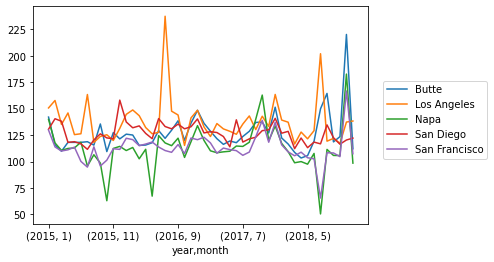

In [40]:
aqi_ca.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'PMs',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

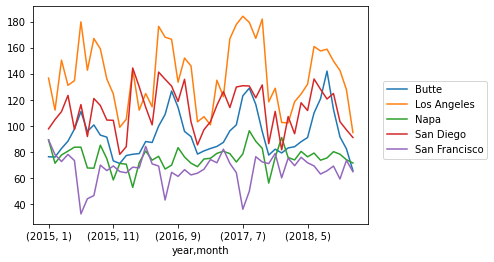

In [35]:
aqi_ca.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'compound',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

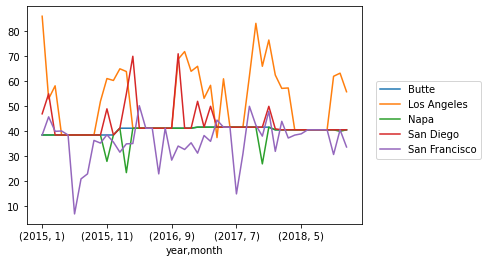

In [49]:
aqi_ca_sub.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'NO2',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

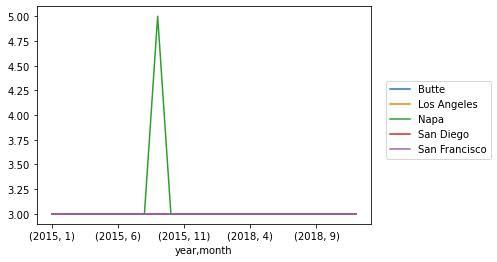

In [50]:
aqi_ca_sub.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'CO',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

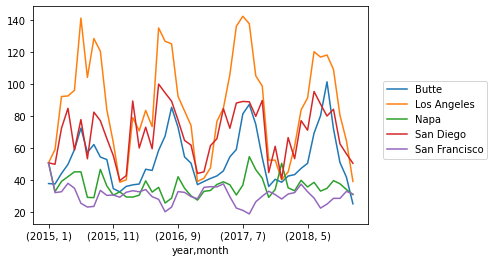

In [51]:
aqi_ca_sub.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'Ozone',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

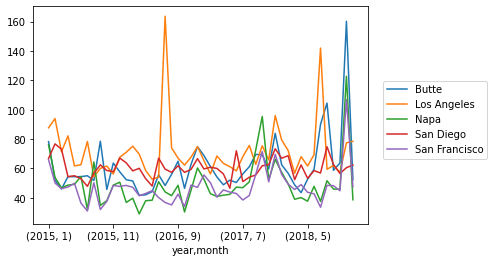

In [52]:
aqi_ca_sub.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'PM2.5',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

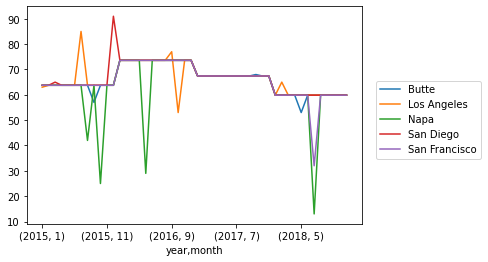

In [53]:
aqi_ca_sub.set_index(['month','year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year','month'], values = 'PM10',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

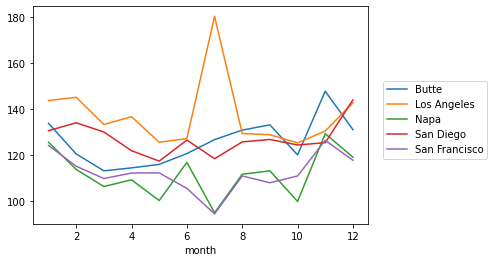

In [36]:
aqi_ca.set_index(['month','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['month'], values = 'PMs',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

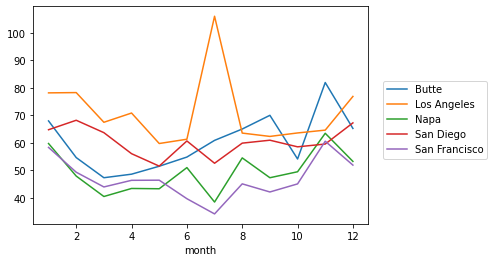

In [54]:
aqi_ca_sub.set_index(['month','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['month'], values = 'PM2.5',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

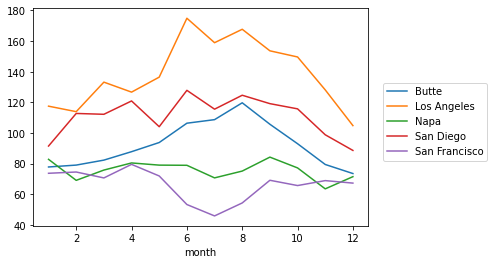

In [38]:
aqi_ca.set_index(['month','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['month'], values = 'compound',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

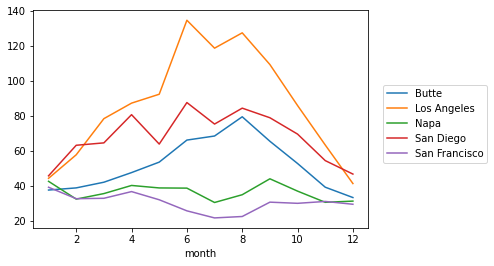

In [55]:
aqi_ca_sub.set_index(['month','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['month'], values = 'Ozone',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

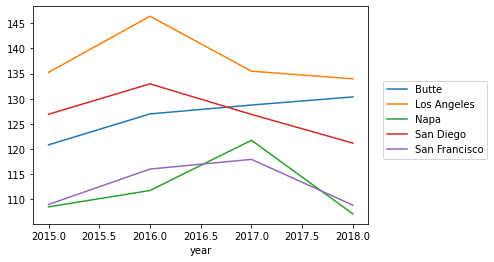

In [41]:
aqi_ca.set_index(['year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year'], values = 'PMs',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

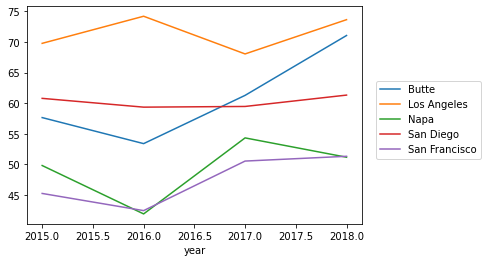

In [56]:
aqi_ca_sub.set_index(['year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year'], values = 'PM2.5',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

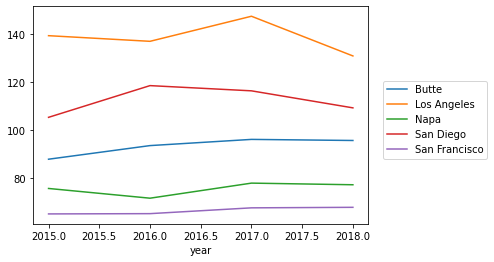

In [42]:
aqi_ca.set_index(['year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year'], values = 'compound',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

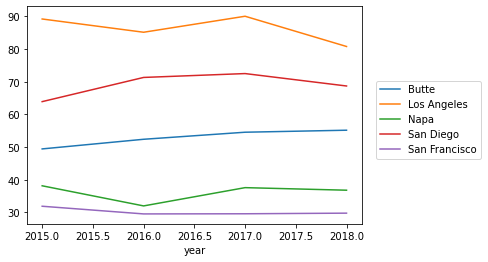

In [57]:
aqi_ca_sub.set_index(['year','county_name'], append=True).pivot_table(index = 'county_name',\
                 columns = ['year'], values = 'Ozone',aggfunc='mean').iloc[[3,17,25,34,35],].T.plot()
plt.legend(bbox_to_anchor=(1.2, 0.3), loc=8, borderaxespad=0.)

Considering data quality and representativity, we will use PM2.5 and Ozone columns for further analysis and modeling.
Also, the source of Ozone pollution is not related to fire, while PM2.5 is. So we calculated the difference between the two values to see the changing pattern across year.

In [58]:
aqi_ca_sub['diff'] = aqi_ca_sub['PM2.5'] - aqi_ca_sub['Ozone']

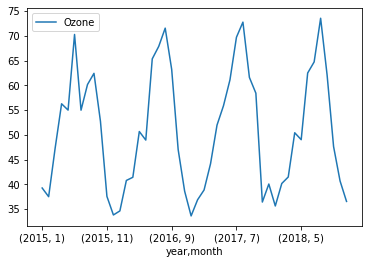

In [97]:
aqi_ca_sub.groupby(['year','month'])[['Ozone']].mean().plot()

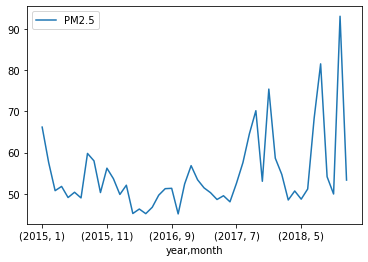

In [98]:
aqi_ca_sub.groupby(['year','month'])[['PM2.5']].mean().plot()

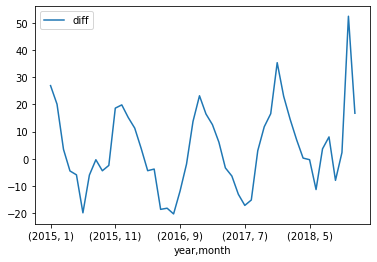

In [66]:
aqi_ca_sub.groupby(['year','month'])[['diff']].mean().plot()

In [67]:
aqi_ca_sub.head()

,month,county_name,CO,NO2,Ozone,PM10,PM2.5,year,SO2,diff
0,1,Alameda,3.0,38.543831,50.615244,63.759075,71.870968,2015,NaN,21.255724
1,1,Alpine,3.0,38.543831,50.615244,63.759075,131.333333,2015,NaN,80.718090
2,1,Amador,3.0,38.543831,18.290323,63.759075,54.379617,2015,NaN,36.089294
3,1,Butte,3.0,38.543831,37.666667,63.759075,78.250000,2015,NaN,40.583333
4,1,Calaveras,3.0,38.543831,30.000000,63.759075,43.500000,2015,NaN,13.500000


In [95]:
aqi_ca1 = aqi_ca_sub.drop(['CO','NO2','PM10','SO2'],axis=1)

In [96]:
aqi_ca1.head(1)

,month,county_name,Ozone,PM2.5,year,diff
0,1,Alameda,50.615244,71.870968,2015,21.255724


In [103]:
aqi_ca1.shape

(3196, 6)

In [68]:
zipcode = pd.read_csv('./data/zip_code_database.csv')

In [99]:
import re

def zipcode_clean(df):
    df['zip'] = df['zip'].astype(str).apply(lambda x: x.zfill(5))
    zip_ca = df[(df['state']=='CA') & (df['type']=='STANDARD')]
    zip_ca = zip_ca[['zip','county']]
    zip_ca['county'] = zip_ca['county'].apply(lambda x: re.search('(\w+\s*\w*)\sCounty',x).group(1))
    
    return zip_ca

In [101]:
zipcode_ca = zipcode_clean(zipcode)
zipcode_ca.head()

,zip,county
38117,90001,Los Angeles
38118,90002,Los Angeles
38119,90003,Los Angeles
38120,90004,Los Angeles
38121,90005,Los Angeles


In [102]:
zipcode_ca.shape

(1601, 2)

In [108]:
aqi_zip = pd.merge(aqi_ca1,zipcode_ca,left_on='county_name',right_on='county',how='left').drop('county_name',axis=1)

In [109]:
aqi_zip.head()

,month,Ozone,PM2.5,year,diff,zip,county
0,1,50.615244,71.870968,2015,21.255724,94501,Alameda
1,1,50.615244,71.870968,2015,21.255724,94502,Alameda
2,1,50.615244,71.870968,2015,21.255724,94536,Alameda
3,1,50.615244,71.870968,2015,21.255724,94538,Alameda
4,1,50.615244,71.870968,2015,21.255724,94539,Alameda


In [116]:
aqi_zip['index'] = (aqi_zip['year']+1).astype(str)+'-'+aqi_zip['month'].astype(str).apply(lambda x:x.zfill(2))+'-'+aqi_zip['zip'].astype(str)

In [117]:
aqi_zip

,month,Ozone,PM2.5,year,diff,zip,county,index
0,1,50.615244,71.870968,2015,21.255724,94501,Alameda,2016-01-94501
1,1,50.615244,71.870968,2015,21.255724,94502,Alameda,2016-01-94502
2,1,50.615244,71.870968,2015,21.255724,94536,Alameda,2016-01-94536
3,1,50.615244,71.870968,2015,21.255724,94538,Alameda,2016-01-94538
4,1,50.615244,71.870968,2015,21.255724,94539,Alameda,2016-01-94539
...,...,...,...,...,...,...,...,...
92618,12,28.769231,51.277778,2018,22.508547,95645,Yolo,2019-12-95645
92619,12,28.769231,51.277778,2018,22.508547,95691,Yolo,2019-12-95691
92620,12,28.769231,51.277778,2018,22.508547,95694,Yolo,2019-12-95694
92621,12,28.769231,51.277778,2018,22.508547,95695,Yolo,2019-12-95695


In [112]:
aqi_zip.zip.nunique()

1546